# Data PreProcessing

In [ ]:
!pip install -q geopandas
!unzip -q Colab.zip

from tqdm.notebook import tqdm
import geopandas as gpd

In [ ]:
counties = gpd.read_file('Colab/FloridaCounties')
print(counties.crs)

epsg:3086


In [ ]:
# Airports
airports = gpd.read_file('Colab/airports_2018').to_crs('EPSG:3086')
for ix, rec in tqdm(counties.iterrows(), total=len(counties)):
    counties.at[ix, 'airports'] = len(airports[airports.within(rec.geometry)])
counties.head(5)

,ID_2,NAME_2,geometry,airports
0,318,Alachua,"POLYGON ((554231.745 609705.424, 545965.195 60...",16.0
1,319,Baker,"POLYGON ((587687.143 683284.678, 578693.360 68...",2.0
2,320,Bay,"MULTIPOLYGON (((222511.864 689163.268, 222485....",15.0
3,321,Bradford,"POLYGON ((587687.143 683284.678, 587895.103 67...",2.0
4,322,Brevard,"MULTIPOLYGON (((720976.005 485979.377, 721088....",20.0


In [ ]:
# Landuse
landuse = gpd.read_file('Colab/gis_osm_landuse_a_free_1').to_crs('EPSG:3086')
fields = landuse.fclass.unique()
for ix, rec in tqdm(counties.iterrows(), total=len(counties)):
    for cls in fields:
        temp = landuse[landuse.fclass == cls]
        counties.at[ix, cls] = len(temp[temp.within(rec.geometry)])
counties.head(5)

,ID_2,NAME_2,geometry,airports,cemetery,residential,park,forest,scrub,industrial,military,nature_reserve,retail,commercial,recreation_ground,heath,orchard,farmland,meadow,quarry,grass,farmyard,vineyard,allotments
0,318,Alachua,"POLYGON ((554231.745 609705.424, 545965.195 60...",16.0,8.0,672.0,93.0,136.0,11.0,22.0,3.0,28.0,20.0,184.0,22.0,0.0,1.0,43.0,6.0,3.0,304.0,18.0,0.0,0.0
1,319,Baker,"POLYGON ((587687.143 683284.678, 578693.360 68...",2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,320,Bay,"MULTIPOLYGON (((222511.864 689163.268, 222485....",15.0,10.0,8.0,47.0,39.0,0.0,4.0,4.0,0.0,5.0,5.0,8.0,0.0,0.0,0.0,0.0,2.0,206.0,2.0,0.0,0.0
3,321,Bradford,"POLYGON ((587687.143 683284.678, 587895.103 67...",2.0,4.0,2.0,4.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,13.0,1.0,0.0,0.0,1.0,0.0,0.0
4,322,Brevard,"MULTIPOLYGON (((720976.005 485979.377, 721088....",20.0,10.0,292.0,177.0,989.0,280.0,67.0,4.0,14.0,98.0,75.0,37.0,2.0,25.0,33.0,19.0,0.0,731.0,14.0,0.0,2.0


In [ ]:
# POIS A (Amenities)

from collections import Counter

amenities = gpd.read_file('Colab/gis_osm_pois_a_free_1').to_crs('EPSG:3086')
fields = [k for k, v in Counter(amenities.fclass).items() if v > 100]
for ix, rec in tqdm(counties.iterrows(), total=len(counties)):
    for cls in fields:
        temp = amenities[amenities.fclass == cls]
        counties.at[ix, cls] = len(temp[temp.within(rec.geometry)])
counties.head(5)

,ID_2,NAME_2,geometry,airports,cemetery,residential,park,forest,scrub,industrial,military,nature_reserve,retail,commercial,recreation_ground,heath,orchard,farmland,meadow,quarry,grass,farmyard,vineyard,allotments,graveyard,post_office,library,attraction,golf_course,college,stadium,hotel,mall,school,sports_centre,pitch,museum,university,police,fire_station,restaurant,dog_park,playground,swimming_pool,cinema,toilet,tourist_info,fast_food,water_tower,doityourself,convenience,shelter,theatre,motel,community_centre,bank,hospital,track,beverages,prison,car_wash,pharmacy,supermarket,cafe,wastewater_plant,camp_site,veterinary,gift_shop,car_dealership,laundry,doctors,clothes,fountain,bar,chemist,department_store,caravan_site,furniture_shop,picnic_site
0,318,Alachua,"POLYGON ((554231.745 609705.424, 545965.195 60...",16.0,8.0,672.0,88.0,136.0,11.0,22.0,3.0,28.0,20.0,184.0,22.0,0.0,1.0,43.0,6.0,3.0,304.0,18.0,0.0,0.0,8.0,5.0,6.0,5.0,6.0,3.0,10.0,13.0,1.0,44.0,23.0,286.0,4.0,3.0,5.0,6.0,31.0,5.0,28.0,140.0,4.0,13.0,2.0,27.0,2.0,3.0,16.0,46.0,3.0,3.0,11.0,9.0,6.0,12.0,2.0,4.0,4.0,8.0,15.0,7.0,5.0,0.0,1.0,0.0,6.0,1.0,0.0,1.0,3.0,0.0,2.0,2.0,0.0,1.0,1.0
1,319,Baker,"POLYGON ((587687.143 683284.678, 578693.360 68...",2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,320,Bay,"MULTIPOLYGON (((222511.864 689163.268, 222485....",15.0,10.0,8.0,46.0,39.0,0.0,4.0,4.0,0.0,5.0,5.0,8.0,0.0,0.0,0.0,0.0,2.0,206.0,2.0,0.0,0.0,10.0,5.0,2.0,1.0,7.0,2.0,0.0,39.0,2.0,35.0,4.0,197.0,3.0,1.0,2.0,9.0,62.0,2.0,27.0,163.0,1.0,11.0,1.0,58.0,3.0,6.0,18.0,16.0,2.0,6.0,1.0,25.0,3.0,3.0,4.0,2.0,3.0,4.0,11.0,4.0,5.0,2.0,1.0,2.0,10.0,5.0,2.0,0.0,0.0,9.0,9.0,8.0,2.0,2.0,8.0
3,321,Bradford,"POLYGON ((587687.143 683284.678, 587895.103 67...",2.0,4.0,2.0,4.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,13.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0,5.0,0.0,20.0,1.0,0.0,1.0,1.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
4,322,Brevard,"MULTIPOLYGON (((720976.005 485979.377, 721088....",20.0,10.0,292.0,177.0,989.0,280.0,67.0,4.0,14.0,98.0,75.0,37.0,2.0,25.0,33.0,19.0,0.0,731.0,14.0,0.0,2.0,10.0,4.0,6.0,14.0,21.0,6.0,5.0,34.0,4.0,137.0,26.0,921.0,5.0,3.0,4.0,13.0,79.0,7.0,111.0,347.0,7.0,22.0,2.0,80.0,2.0,7.0,29.0,87.0,6.0,11.0,9.0,42.0,7.0,29.0,3.0,2.0,8.0,12.0,13.0,5.0,12.0,2.0,7.0,0.0,2.0,0.0,4.0,2.0,13.0,5.0,8.0,8.0,5.0,6.0,1.0


In [ ]:
# Calculate the Area of County
counties['area_m'] = counties.geometry.area

In [ ]:
print(len(counties.columns) - 4)
print(counties.columns)

76
Index(['ID_2', 'NAME_2', 'geometry', 'airports', 'cemetery', 'residential',
       'park', 'forest', 'scrub', 'industrial', 'military', 'nature_reserve',
       'retail', 'commercial', 'recreation_ground', 'heath', 'orchard',
       'farmland', 'meadow', 'quarry', 'grass', 'farmyard', 'vineyard',
       'allotments', 'graveyard', 'post_office', 'library', 'attraction',
       'golf_course', 'college', 'stadium', 'hotel', 'mall', 'school',
       'sports_centre', 'pitch', 'museum', 'university', 'police',
       'fire_station', 'restaurant', 'dog_park', 'playground', 'swimming_pool',
       'cinema', 'toilet', 'tourist_info', 'fast_food', 'water_tower',
       'doityourself', 'convenience', 'shelter', 'theatre', 'motel',
       'community_centre', 'bank', 'hospital', 'track', 'beverages', 'prison',
       'car_wash', 'pharmacy', 'supermarket', 'cafe', 'wastewater_plant',
       'camp_site', 'veterinary', 'gift_shop', 'car_dealership', 'laundry',
       'doctors', 'clothes', 'fountain

In [ ]:
# Write
counties.to_file('counties_attributes.shp')
!mkdir counties_attributes
!mv counties_attributes.* counties_attributes/
!zip -r counties_attributes.zip counties_attributes

# Feature Engineering

In [ ]:
!pip install -q geopandas

import geopandas as gpd
import numpy as np
import pandas as pd

In [216]:
# Read the config file and parse the weights and fields
import configparser

config = configparser.ConfigParser()
config.read('feature_engineering.txt')

weights = {}

# Iterate through Sections
for section in config.items():
    for item in config.items(section[0]):
        key, value = item[0].split('#')[0], float(item[1])
        weights[key] = value

features = list(weights.keys())
assigned_weights = np.asarray(list(weights.values()))
print(f'Total Features: {len(features)}')

Total Features: 88


In [217]:
# Read the shapefile
!unzip -q -o counties_esri.zip

counties = gpd.read_file('counties_esri')
county_names = counties['NAME_2'].tolist()
print(counties.shape)

(67, 104)


In [218]:
# Standardize data
non_numeric_fields = {'area_m', 'geometry', 'ID_2', 'NAME_2', 'aggregatio',
                      'HasData', 'ORINIGAL_O', 'sourceCoun'}
reverse = ['prison', 'crime_crmc', 'crime_crm0', 'crime_crm1', 'crime_crm2',
           'crime_crm3', 'crime_crm4', 'crime_crm5', 'crime_crm6', 'crime_crm7',
           'crime_crm8', 'educationa', 'employment', 'atrisk_tot', 'agedepende',
           'households', 'policy_min', 'military', 'forest', 'farmland']

for fea in set(counties.columns) - non_numeric_fields:

    col = counties[fea]
    col = (col - col.mean()) / col.std()

    labels = range(10, 0, -1) if fea in reverse else range(1, 11)
    counties[fea] = pd.cut(col, bins=10, labels=labels)

print(counties[features].head())

  prison crime_crmc crime_crm0  ... wastewater keyusfacts historical
0      5          9          6  ...          3          4          2
1     10          8          9  ...          1          2          1
2      8          8          7  ...          3          3          1
3      7          9         10  ...          1          1          1
4      8          8          7  ...          8          4          3

[5 rows x 88 columns]


# Weighted Analysis

In [222]:
# Weighted Analysis
prod = (counties[features].values * assigned_weights).sum(axis=1)
a, b = 0.01, 0.99
prod = ((b - a) * (prod - prod.min()) / (prod.max() - prod.min())) + a

# Sort the records
result = pd.DataFrame(zip(county_names, prod), columns=['County', 'Index'])
sorted = result.sort_values('Index', ascending=False)
sorted['Rank'] = range(1, len(county_names) + 1)
sorted['Color'] = sns.color_palette('RdYlGn', len(result))[::-1]

# Print
print(sorted[['Rank', 'County', 'Index']].to_string(index=False))

 Rank        County     Index
    1        Orange  0.990000
    2      Pinellas  0.947097
    3  Hillsborough  0.833441
    4       Broward  0.789785
    5         Duval  0.731075
    6    Miami-Dade  0.633226
    7    Palm Beach  0.627204
    8       Volusia  0.582796
    9         Pasco  0.544409
   10   Saint Johns  0.539892
   11           Lee  0.527097
   12      Sarasota  0.518817
   13       Brevard  0.492473
   14       Collier  0.454086
   15       Manatee  0.440538
   16      Okaloosa  0.425484
   17          Polk  0.408172
   18        Monroe  0.390108
   19         Dixie  0.375806
   20    Santa Rosa  0.375806
   21          Lake  0.374301
   22  Indian River  0.369785
   23        Martin  0.368280
   24          Leon  0.366774
   25       Liberty  0.354731
   26       Wakulla  0.354731
   27      Seminole  0.351720
   28      Escambia  0.346452
   29     Gilchrist  0.342688
   30     Charlotte  0.323118
   31    Washington  0.318602
   32         Union  0.315591
   33     

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set(font_scale=0.75)
sns.set_style('whitegrid', {'axes.grid' : False})
plt.figure(figsize=(4, 9), dpi=100)
sns.set_context(rc={'patch.linewidth': 0.2})

sorted = sorted.sort_values('County')
sns.barplot(x='Index', y='County', data=sorted, palette=sorted['Color'],
            edgecolor='black')
sns.despine(offset=0)
plt.xlabel('Living Index')
plt.tight_layout()
plt.savefig('Weighted_Analysis.png', dpi=1200)
plt.show()

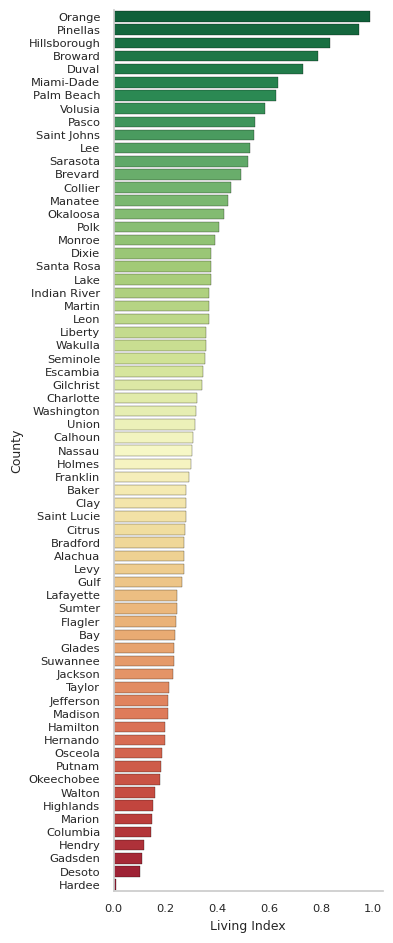

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set(font_scale=0.75)
sns.set_style('whitegrid', {'axes.grid' : False})
plt.figure(figsize=(4, 9.5), dpi=100)
sns.set_context(rc={'patch.linewidth': 0.2})

pal = sns.color_palette('RdYlGn', len(result))[::-1]
sns.barplot(x='Index', y='County', data=sorted, palette=pal,
            edgecolor='black')
sns.despine(offset=0)
plt.xlabel('Living Index')
plt.tight_layout()
plt.savefig('Weighted_Analysis_sorted.png', dpi=2000)
plt.show()

In [233]:
sns.color_palette('RdYlGn', 10)

[(0.8239138792772011, 0.16978085351787775, 0.15255670895809306),
 (0.9345636293733179, 0.38054594386774315, 0.24121491733948483),
 (0.9817762399077278, 0.6073817762399076, 0.3457900807381776),
 (0.9946943483275663, 0.8092272202998846, 0.48696655132641287),
 (0.9982314494425221, 0.9451749327181853, 0.6570549788542868),
 (0.9327950788158401, 0.9717031910803537, 0.6570549788542869),
 (0.7803921568627453, 0.906805074971165, 0.49942329873125735),
 (0.5771626297577857, 0.8186851211072665, 0.40761245674740487),
 (0.3415609381007305, 0.7127258746635909, 0.37362552864282966),
 (0.09196462898885044, 0.5776239907727797, 0.30411380238369856)]

In [309]:
# Write
counties['Index'] = result['Index']
out = gpd.GeoDataFrame(counties[['NAME_2', 'Index']],
                       geometry=counties['geometry'],
                       crs=counties.crs)
out.to_file('counties_index.shp')
!rm -f counties_index.zip
!mkdir counties_index
!mv counties_index.* counties_index/
!zip -q -r counties_index.zip counties_index
!rm -rf counties_index

# SOM

In [502]:
!pip install -q MiniSom

from collections import Counter
from minisom import MiniSom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

counties = gpd.read_file('counties_esri')
for fea in set(counties.columns) - non_numeric_fields:
    col = counties[fea]
    counties[fea] = (col - col.mean()) / col.std()
data = counties[features].values

som = MiniSom(x=8, y=5, input_len=len(features), sigma=2.5, learning_rate=2,
              neighborhood_function='gaussian', random_seed=2467)
som.train(data=data, num_iteration=10000)

som_coords = [som.winner(i) for i in data]

In [505]:
from bokeh.models import HoverTool, LabelSet
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.palettes import RdYlGn11
from bokeh.io import show, output_file

output_notebook()

x = np.asarray([c[0] for c in som_coords])
y = np.asarray([c[1] for c in som_coords])

p = figure(title='SOM Map', match_aspect=True, plot_width=800, plot_height=800,
           tools='pan,box_zoom,reset', background_fill_color='white')
p.grid.visible = False
p.axis.visible = False

# HexBin
r, bins = p.hexbin(x, y, size=0.7, palette=RdYlGn11)

# Point
pt_source = ColumnDataSource(data=dict(x=x, y=y, label=county_names))
r = p.circle('x', 'y', color="red", line_width=5, source=pt_source)
p.add_tools(HoverTool(tooltips=[('', '@label')],
                      mode="mouse", point_policy="follow_mouse",
                      renderers=[r]))

output_file('som.html')
show(p)

# Experiments

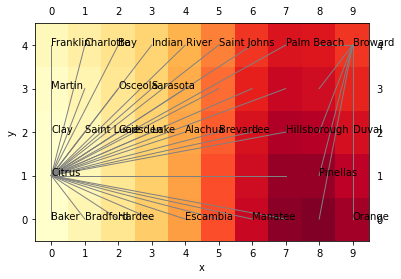

In [ ]:
# POPSOM - https://github.com/njali2001/popsom

!wget -q https://raw.githubusercontent.com/njali2001/popsom/master/popsom.py -O popsom.py
import popsom as som

labels = counties_std['NAME_2'].tolist()
data = counties_std[fields]
m = som.map(xdim=10, ydim=5)
m.fit(data, labels)

m.starburst()

In [94]:
# Random Weights
random_weights = np.random.uniform(-1, 1, len(features))
random_weights = random_weights / random_weights.sum()

prod = (counties[features].values * random_weights).sum(axis=1)
prod = (prod - prod.min()) / (prod.max() - prod.min())
result = pd.DataFrame(zip(county_names, prod), columns=['County', '%'])
result.sort_values('%', ascending=False).head()

,County,%
14,Duval,1.000000
42,Miami-Dade,0.998962
15,Escambia,0.769723
18,Gadsden,0.752733
5,Broward,0.738036
